for mccy probably

In [32]:
MINISTRY = 'MCCY'

In [33]:
import sys
sys.path.extend(['D:\\Documents\\GitHub\\pq-analyzer\\env', 'D:\\Documents\\GitHub\\pq-analyzer\\env\\lib\\site-packages'])

In [34]:
import pandas as pd
import numpy as np
from collections import Counter
import pickle
from umap import UMAP

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

from IPython.core.interactiveshell import InteractiveShell
import sys
InteractiveShell.ast_node_interactivity = 'all'
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold = sys.maxsize)
pd.options.display.html.use_mathjax = False

from utils import *

In [35]:
df = pd.read_csv('pqs_processed.csv', sep='|')
print('Number of rows:', len(df))
df.head(2)

Number of rows: 19133


asker_name                     asker_party asker_parliaments  \
0      Lee Bee Wah           People's Action Party      (11, 12, 13)   
1  K Thanaletchimi  Nominated Member of Parliament             (13,)   

                                                                                                                     askees  \
0  ('Minister for the Environment and Water Resources', 'Senior Minister of State for the Environment and Water Resources')   
1  ('Minister for the Environment and Water Resources', 'Senior Minister of State for the Environment and Water Resources')   

  askees_portfolios  \
0          ('MSE',)   
1          ('MSE',)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [36]:
# Storing variables of stopwords and phrases generated in session-2-1
with open('stopwords.pkl', 'rb') as f:
    stop_words = pickle.load(f)

In [37]:
qn_vocab = pd.read_csv('qn_vocab.csv')
qn_vocab.head(2)

#fb_vocab = fb_vocab['word/phrase'].tolist()

,word/phrase,score
0,aar,2.208565
1,ab,1.504794


In [38]:
qn_vocab.sort_values(by = 'score', ascending = False).head(100)

,word/phrase,score
4599,government,312.142946
7524,number,297.004092
12326,work,286.089066
9794,school,284.184516
8793,public,276.121779
...,...,...
7958,part,105.279328
4870,healthcare,104.908800
4113,find,104.022174
288,agency,103.406239


In [39]:
qn_raw_col = 'question'
qn_col = 'question_cleaned'

qn_df = df[df[qn_raw_col].notnull()].copy().reset_index(drop = True)
print('Number of qn rows:', len(qn_df))
qn_df[[qn_raw_col, qn_col]].head(2)

Number of qn rows: 19133


question  \
0  Mdm Chair, I beg to move, "That the total sum to be allocated for Head L of the Estimates be reduced by $100". According to the International Energy Agency (IEA), the global energy intensity − the amount of energy used per unit of gross domestic product (GDP) − improved by 1.8% in 2015. This surpassed the 1.5% gain seen in 2014, and triples the annual rate of 0.6% seen in the previous decade, according to IEA Energy Efficiency Market Report for 2016. But the report added that and I quote: "However, global progress on energy intensity is still too slow, falling short of putting the world onto a sustainable pathway toward a decarbonised energy system. IEA analysis shows that annual energy intensity improvements need to rise immediately to at least 2.6% in a trajectory consistent with our climate goals." I would like to ask the Minister how is our performance in industrial energy efficiency efforts compared with other countries? What is the feedback from industries on the obstacles they are facing and what can the Ministry do to address these concerns? How are we to fulfil our commitment to the Paris Agreement? Are there any new plans to improve on our industrial energy efficiency? Our city state has done well in managing the air quality from vehicle emission. Unlike the days before year 2000, certainly we hardly see smoky vehicles on our roads, except some from across the causeway. Even the public can report to NEA if they see any smoky vehicles on our road. NEA requires periodic checks for buses and diesel vehicles and we strive to reduce domestic emissions to meet the 2020 air quality targets benchmarked against WHO standards. We have been successful and there are lessons to be learnt from what is happening in China, India and France where smoke from vehicle emission had created havoc on the ambient air quality. The toll can be very serious as we can see how the haze impacted the health of the people. WHO has pointed out that air pollution pose one of the biggest environmental health risks, especially for heart diseases. Can the Minister update the House on what is the strategy to achieve these targets and what has been done so far to improve the air quality in Singapore? Diesel vehicles are found to be the major culprit in polluting the air. In December 2016, four of the world's largest and most polluted cities have decided to ban diesel cars and trucks from their streets by 2025. Diesel engines emit particulates into the air at ground level, as well as emit nitrogen oxides. Nitrogen oxides can help form ground-level ozone, which can lead to breathing difficulties for those suffering from respiratory problems. According to WHO, seven million deaths every year are linked to exposure to outdoor air pollution. At the last COS debate, we were told that a study on diesel vehicles would be undertaken by SUTD. I understand that it has recently submitted a report on alternative technologies to the Ministry. Can the Minister share with the House the outcome of this study? What next after this? There are some older commercial vehicles retained by their owners which do not meet current day emission standards. What are the Ministry's plans to address these old commercial vehicles? Will the ETS be extended? Apart from this, what are plans to curb emission from petrol cars and motorcycles? Next, I would like to briefly point out that there is much that can be done to improve the waste collection system. Frequently, we can see cleaners manually hauling refuse to the bin centres from the chutes at the HDB blocks. This gives rise to complaints from residents about the odour and the spread of pests when this exercise is not done properly. Are there any plans for the Ministry to improve on this waste disposal by cleaners? I note that the cost of water supply has risen over the years and the Government is raising prices by 30% in two phases from this July. I think what we need to do is to share with Singaporeans what the Governmen

In [40]:
df_ministry = df[df['askees_portfolios'].str.contains(MINISTRY)].copy()
df_ministry.shape

(1052, 20)

## 1. Unguided Topic Modelling for Feedback

This gives us a sense of what the underlying topics may be, before we "tease" out topics using anchor words/phrases.

### 1.1. Fitting the Topic Model

In [41]:
data = df_ministry[qn_col].tolist()

In [42]:
# results r q dependent on random seed. so we try a few seeds until we find a good one. good meaning about 20-40% unlabeled stuff
# dun ask me why, gin/weiling said that's a good num and ig it makes sense

topic_model, frequency, topics, probs = get_bert_topics(data, seed=5)
frequency

topics: 19
Number of question rows with no topic: 285 (27.1%)


,Topic,Count
0,-1,285
1,0,216
2,1,126
3,2,52
4,3,49
5,4,45
6,5,33
7,6,31
8,7,29
9,8,28


In [43]:
df_ministry['question_topic'] = topics
df_ministry[[qn_raw_col, qn_col, 'question_topic']].head(2)

question  \
488  Mr Chairman, I beg to move, "That the total sum to be allocated for Head X of the Estimates be reduced by $100." Before I begin, let me wish all the ladies here "Happy Women's Day". Our Nation, Singapore is a young country. We are celebrating our 54th National day this August. The task of nation building is an endless one. It is one that needs all Singaporeans regardless of race, language or religion to come together, rally together as one united people and one nation. We come together to celebrate every success Singapore achieved, to celebrate our uniquely Singaporean culture, food, arts and sports. It only seems like not so long ago when young Singaporean were thought to be politically and socially apathetic. Yet today, we have an increasingly mature citizenry with a diverse array of views and hopes for their own future, and for the future of Singapore. These can be attributed to a society with growing literacy and affluence, where they are able to take the focus off from bread and butter issues to other matters and issues that affect their lives. The widespread use of social media certainly helps them and rallies them in expressing their views. And, the Government needs to do more to engage and partner Singaporeans in the next exciting phase of nation building. Our youths and our older Singaporeans who have found common ground have bandied together and created groups to promote their causes. They participate in forums and focus group discussions. They are vocal on social media, some are more sophisticated with their analyses and feedback, others less so. But it is evident that many Singaporeans would like to have an active role in nation-building and shaping the future. Some expressed their views through arts, music and culture. However, some are unsure of the available avenues, or lack the capability to do so. MCCY has been taking the lead in ensuring that citizens are actively involved in our nation building, in policy deliberation and design. Online feedback portals, community outreach events, facilitation of networking events for stakeholders and volunteers to come together are some examples of ways in which Singaporeans can engage in nation-building. Nevertheless, majority of the engagement feels top-down, in the sense that citizens provide feedback, and Government works on it. We need to move away from a top down approach to a less paternalistic approach. The Government need to create more space, room and opportunities for Singaporeans to participate. For those who are ready to do more, particularly Singaporeans with leadership qualities, good ethics and are socially well-connected, they should have more opportunities to participate. They could create social projects and lead teams of volunteers. For those who are not ready, perhaps they lack comprehension of policies, or skills to articulate their aspirations and feedback, and we must help them to grow their capability. This can be done through giving them access to the necessary information, and the skills to participate. Many Singaporeans still find certain policies to be too complex to understand and they do not get why certain policies have to be this way. If the Ministry could come up with more creative means to break down these policies for the layman, that would be helpful. It is prudent that all citizens in Singapore have a stake in nation-building, to ensure equality and for everyone’s interests to be cared for. Our population has always been and will always be our best resource, and with a more well-informed population, there will be more and better possibilities. As we face more complex issues, we will be able to tap on the collective wisdom and expertise of our citizenry. There is strength in numbers; as we build Singapore together, we can work towards creating the best Singapore that we can, one that all citizens have a stake in. I would like to ask how will the Ministry continue engaging citizens in nation-building? How can we raise the

### 1.2. Examining the Results

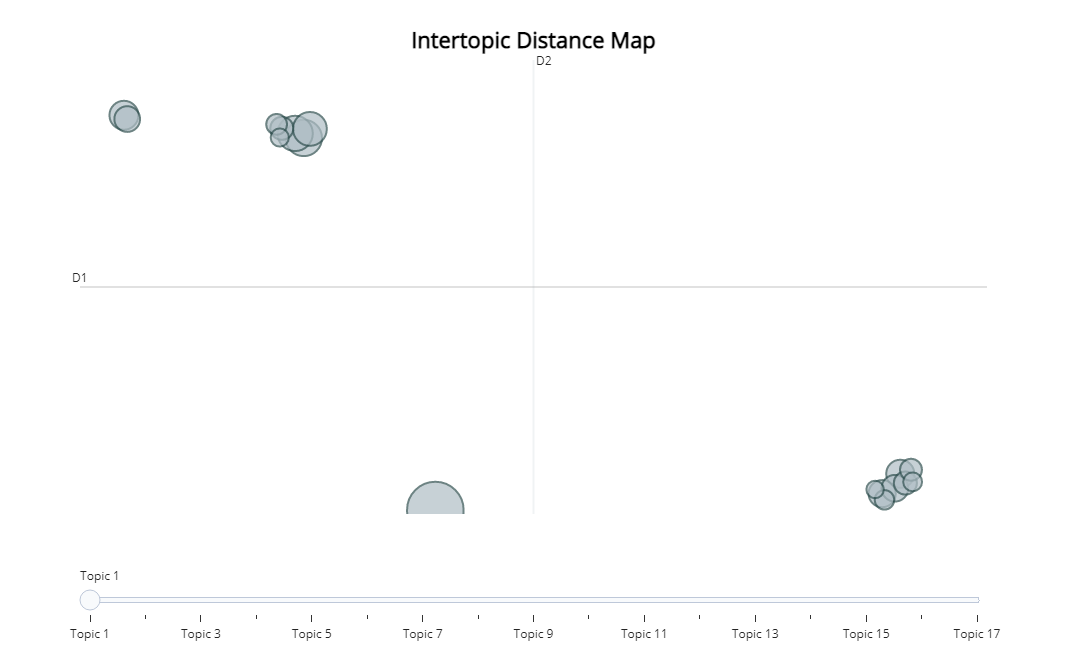

In [44]:
fig = topic_model.visualize_topics()
fig.write_html(f'pqs_unguided_{MINISTRY.lower()}_topic_distance.html')
fig

In [45]:
# Getting representative documents for each topic
representative_docs = topic_model.get_representative_docs()

representative_docs_preprocessed = dict()
for topic_num in representative_docs.keys(): 
    entries = []
    for text in representative_docs[topic_num]:
        entries.append(df_ministry[df_ministry[qn_col].str.contains(text)][qn_raw_col].values[0]) # Obtain original text
    representative_docs_preprocessed[topic_num] = entries
    
for i in range(max(topics)+1): 
    print('Topic #'+str(i))
    print('Topic Size: ' + str(Counter(topics)[i]))
    print([x[0] for x in topic_model.get_topic(i)[:15]])
    
    display(pd.DataFrame(representative_docs_preprocessed[i]))
    print('-------------------------------')

Topic #0
Topic Size: 216
['sport', 'athlete', 'game', 'football', 'hub', 'sport hub', 'stadium', 'sport facility', 'coach', 'disability']


,0
0,"(a) whether the public-private partnership between the Government and the Sports Hub remains viable and sustainable given the recurring concerns over operational, structural and management issues in the past two years; and (b) whether SportSG have officers experienced enough to deal effectively with the consortium managing the Sports Hub."
1,"(a) why the 2012 Memorandum of Understanding between OCBC Bank and the Singapore Sports Hub Consortium for naming rights to the Sports Hub was not approved by the Government; (b) whether the Ministry and the Singapore Sports Council could have better managed the process with clearer guidelines on the naming rights to the Sports Hub facilities; (c) if he will provide an update and details on the naming of the individual Sports Hub facilities, including the naming rights sale and revenue generated thus far; and (d) how does the Ministry ensure that fair value has been obtained in any naming rights sale."
2,"Chairman, I would like to speak briefly about sports today – the role of sports in our lives and in our community. And I would like to start by recalling Minister Edwin Tong's response to one of my Parliamentary Questions recently. In his response, Minister laid out very comprehensively the overall framework – of our sporting system, sporting programmes and sporting infrastructure – and at various levels, from sports in the community, to sporting performance at the highest level. And his response reminded me then that sports is a little bit like clean air in our lives; we tend to forget that it is there, until it is no longer there. But I think through years of effort, we have built up a framework that has allowed sports to become so integral – a part of our lives and our community here in Singapore. It is in this spirit that I raise two questions, around what more we can do to strengthen the role of sports in our lives and our community. First, on inclusive sports. Sports has the power to uplift and empower individuals. It uplifts the spirit, it allows for the display and expression of talent and flair, it can help a person discover him or herself. By extension, sports has the power to uplift and empower whole segments in society – more vulnerable children, youths at risk, persons with disabilities, seniors. It can transform lives. The Delta League by the Home Team is a good example. And SportSG has also launched the SportCares programme. So, can MCCY share its future plans on its SportCares programme, so that we can continue to grow a movement of inclusive sports to transform lives in Singapore? Chairman, second, on high-performance sports. As Singaporeans, we cheer our national athletes on when they compete, we celebrate with them when they win and partake in their disappointment when they do not. But I think we will reach the next level in our high-performance sporting culture here in Singapore when we can go beyond spectatorship, transcend spectatorship, to be an active part of the system and an active part of the movement. And in this respect, MCCY has created a One Team Singapore Fund (OTSF), where individuals and corporates can make donations with dollar-for-dollar matching by the Government. Can MCCY share its future plans on this Fund, so that we can continue to encourage a spirit of giving towards high performance sports in Singapore?"


-------------------------------
Topic #1
Topic Size: 126
['art', 'heritage', 'artist', 'art group', 'cultural', 'art culture', 'museum', 'theatre', 'hawker', 'creative']


,0
0,"with regard to the upcoming survey on intangible cultural heritage (a) how will the vendors be evaluated for their expertise in conducting the survey; (b) whether all findings of the survey and findings from previous research done by the National Heritage Board will be released to the public and, if not, why not; and (c) whether there will be extensive public consultations in the creation of the national inventory."
1,with regard to heritage artefacts excavated by archaeologists or others in the last five years (a) whether all the artefacts have been properly documented and reported to the Government; (b) what is the legal ownership status of such artefacts; and (c) how are the artefacts stored and protected.
2,"A report in Zaobao's arts section yesterday quoted Cai Shiji, Creative Director of Dance Ensemble Singapore. She said that as a successor of Chinese dance performance in Singapore, her dances were Chinese dance infused with new elements. She hopes that policymakers will not drag their feet and lock themselves in the old mindset where ""modern dance movements should not be seen in Chinese dances"" and, hence, restricting the new forms of Chinese dances. Otherwise, sooner or later, Chinese dances will have no young audiences. May I ask the Senior Parliamentary Secretary what is the definition of traditional arts? Would the new forms of Chinese dance or other traditional arts infused with new elements be eligible for grants under the Traditional Arts Plan?"


-------------------------------
Topic #2
Topic Size: 52
['muslim', 'asatizah', 'religious', 'malay muslim', 'muslim community', 'mendaki', 'islamic', 'career', 'skill', 'malay muslim community']


0
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

-------------------------------
Topic #3
Topic Size: 49
['madrasah', 'religious', 'teacher', 'madrasah student', 'irsyad', 'islamic', 'asatizahs', 'tanjong', 'muslim', 'wak tanjong']


,0
0,"Last year, the Minister announced plans for Madrasah Al-Arabiah to have a new home in Toa Payoh. This is good news as the existing building is old and a makeover is long overdue. However, what is important to me is the madrasah's environment, and not merely its physical aspect. These days, mainstream schools that are part of the national education system are equipped with facilities and technology to keep up with the times and provide the children with the necessary exposure to the relevant technology. I would like to know how the building design and the infrastructure of the new madrasah will encourage the learning of new skills and knowledge among its students, and are also relevant for our modern society in this digital era? Furthermore, how can the students and the school interact with and contribute to the heartland community around the area? Thank you."
1,"whether visitations to, and sharing of the work done by the Religious Rehabilitation Group (RRG) can be embedded into the curriculum of every cohort of asatizah as well as Secondary and post-Secondary madrasah students."
2,"Our madrasahs are key institutions that produce our future leaders and religious teachers to guide and provide advice to the Malay/Muslim community on religious matters in a context that is suited to our multi-racial and multi-religious society, and our customs. Several of our madrasahs also have long histories and legacies that can reflect the development of Islam and the Malay/Muslim community here. Madrasah Wak Tanjong is one such institution. I understand that Madrasah Wak Tanjong, which has a very long history and legacy, is due for its lease renewal and this involves very high costs. May I ask the Minister how MUIS plans to help Madrasah Wak Tanjong in this matter to ensure that the legacy and history of Madrasah Wak Tanjong can be preserved?"


-------------------------------
Topic #4
Topic Size: 45
['mendaki', 'primary', 'operator', 'childcare', 'skill', 'mt', 'school education', 'primary school', 'kmm', 'childrens']


,0
0,"Mr Chairman, I am deeply heartened by Deputy Prime Minister Tharman’s announcement that the needs of children with mild speech, language and learning delays will be addressed through the Development Support Programme (DSP). This will certainly close the gap and help these children cope and stay within mainstream education. However, we are also aware of the global shortage of therapists, and Singapore is certainly not spared from this. To this end, how can MCYS ramp up the manpower capacity as soon as possible to extend the outreach beyond the 2,000 children who will benefit under this new programme? 11.30 am In addition, can MCYS provide an update of the Place-and-Train scheme that was announced in October 2011 to allow EIPIC teachers and therapists to be hired ahead of enrolment? Are all our pre-school teachers trained to detect and provide early interventions for children with learning difficulties? We all know every child is precious. Early detection and intervention can certainly improve the child’s chance of progress tremendously. We cannot afford to let any child fall through the cracks. Sir, I would also like to ask if MCYS would be harmonising its programmes with MOE to reach pre-schoolers in kindergartens. Will there be coordinated efforts that will maximise joint resources and expertise and make best use of the limited manpower capacity in this area? In addition, I would like to know if the MCYS is considering instituting a screening process in all pre-schools and childcare centres to detect children with learning difficulties. The recent MCYS' Enabling Masterplan highlighted that there is currently a screening gap between the ages of 18 months and three years in a child’s life. This period is certainly critical to detect developmental disorders for this is when the child develops further in his or her motor, speech and social skills. How can doctors, parents and caregivers be alerted to take note of this condition? Let us all ensure that no child gets left behind. Developing a Sporting Culture"
1,in view of the doubling of new cases of preschoolers diagnosed with developmental problems from 2005 to 2010 (a) what is the number of such children being placed on early childhood intervention programmes for the past five years; (b) what is the current number of children on the waiting list and the average waiting time before such preschoolers can be placed on these programmes; and (c) what are the enrolment figures at Special Education (SPED) schools for this group of preschoolers in the past five years.
2,"Thank you, Mr Chairman. I am glad the Acting Minister emphasised inclusiveness as MCYS' theme. I have two questions relating to his reply on my cut. He mentioned that there are 240 centres that are KiFAS-approved. I like to know whether there are any non-PCF centres included in the list. The second question is that he said that KiFAS is targeted at lower income families. It is a child and family specific scheme and not centre-specific. I understand, so is CFAC which is for childcare and we have KiFAS which is for kindergarten. But I understand CFAC is inclusive; all operators included, including private centres are eligible. But KiFAS is exclusive; so far only to one organisation. I am sorry I do not understand the Acting Minister’s explanation and I do not understand the reasons behind KiFAS’ very onerous criteria."


-------------------------------
Topic #5
Topic Size: 33
['charity', 'cdc', 'cc', 'tuition', 'charitable', 'fund raise', 'donation', 'cdc comcare', 'comcare', 'fundraise']


,0
0,"(a) in the last five years, what is the amount of corporate donations received by the Community Development Councils (CDCs) collectively; and (b) of this amount, how much has been passed on to its partners that are social service agencies."
1,"for FY2015/16 what is (i) the amount of income earned by grassroots organisations (GROs) from community trade fairs (ii) the percentage of the earned income used by GROs for welfare assistance, scholarships and bursaries and (iii) the amount of sponsorships in kinds and cash collected by the GROs for staging community events."
2,"Madam, community centres (CCs) provide community services to meet the needs of our residents. CCs are managed by local community leaders and volunteers. They determine the mix of services and programmes in consultation with the residents. Examples include social services, after school care, tuition and other forms of support. I can understand Assoc Prof Daniel Goh's concerns with the local tuition culture. There are many forms of tuition and student guidance services. They range from those providing help to students who need more guidance to keep pace with their school work; to others who are pursuing excellence in some subjects. The range of providers include volunteers helping less privileged students, as well as paid, organised classes. Stopping the conduct of all tuition classes in CCs will remove access to affordable services that some residents and students legitimately need. On the other hand, many other things will need to be done to change the broader tuition culture that Assoc Prof Daniel Goh speaks of. Our communities will have to determine the balance and the type of services that they wish to provide and access at all CCs."


-------------------------------
Topic #6
Topic Size: 31
['generation', 'asean', 'aspiration', 'national youth', 'enterprise', 'volunteerism', 'social enterprise', 'youth programme', 'young people', 'engage youth']


,0
0,"Chairman, our youths will inherit our future, and we should continue to engage them to participate and contribute actively to matters of our national concern that will also impact our society. Over the years, I understand that MCCY has announced several initiatives, such as the SG Youth Action Plan and Youth Action Challenge, to actively engage our youths and listen to their views. Can MCCY provide an update the effectiveness of these engagements and what else will be done to engage our youths from diverse backgrounds, so that they can partner with the Government and society to work on hot-button issues and issues that they care about, and to do so on a regular and sustainable basis?"
1,"(a) whether there any initiatives to support youths who are engaged in the unskilled gig economy and who want to move away from it; and i(b) if so, what are the current efforts being made to ensure that the youths are aware of these opportunities."
2,"Mr Chairman, first, let me declare my interest as a member of the National Youth Council. Douglas MacArthur once said, ""You are as young as your faith, as old as your doubt, as young as your self-confidence, and as old as your fear. But when your heart is covered with the snows of pessimism and the ice of cynicism, then and then only are you grown old."" Mr Chairman, when once we spoke of youth, the word ""apathy"" almost as naturally rolled off the lips of many. It was George Bernard Shaw who also once said, ""Youth is wasted on the young."" Yet, the image of a laissez-faire apathetic youth is a false one, at least not with the youths I have met, whether it is polytechnic students lobbying for fare concessions, hot-blooded eco-warriors advocating for animal rights or protecting our environment, or the teams of YEC activists quietly serving their communities, reaching out to the less fortunate. And, more importantly for me, the many young workers in the NTUC who have given their time and continue to give their time to serve their fellow workers in the Labour Movement, using their youthful passions to ensure that workers’ rights are defended. Page: 2437 Sir, these and many others are just examples of a small sampling of the endless plethora of causes that young people – young Singaporeans – are engaged with. With the advent of social media, every youth can now count himself as an activist, a campaign manager, an advocate for various causes. We are witnessing, perhaps, a new spring of activism. The groups and organisations may be different from the past but the passions are the same. The generations before us may look at us and say ""Why did we turn out the way we did?"" And, we, too, will look at the generation after and say the same. Yet, each generation will find its own heroes. Each generation will champion its own causes. Amidst this changing youth landscape and rapidly evolving social media whirlpool, the NYC, which saw it genesis in 1989, seems almost arcane with the mushrooming of different animal welfare groups. Even old stalwarts like the SPCA have to compete for attention in an overcrowded space, likewise, the situation for the NYC. As such, there is perhaps no more opportune time than now to ask if the NYC still has a role to play and how this grand dame of youth organisations see itself vis-a-vis other youth organisations. With the multiplication of youth opinion leaders, how then does the MCYS – the Ministry for youths – plan to continue to nurture these budding leaders so that there is a coherent voice? So, perhaps now, this impetuous youth begs to differ from the Nobel Laureate that youths of Singapore are certainly not wasting their time or their youth. My only hope is their hearts will not be filled gradually by pessimism and cynicism. Youth-at-risk: Reaching out My second cut relates to a group of youths where the passions of youth may have led them astray. The Central Youth Guidance Office has played a crucial role since its formation. In Budget 2011, a $1.2 million pilot

-------------------------------
Topic #7
Topic Size: 29
['pa', 'political', 'grassroots', 'political party', 'appoint', 'letter', 'government agency', 'adviser', 'branch', 'town council']


,0
0,(a) what are the respective roles of grassroots advisors (GAs) and elected Members of Parliament (MPs) in deciding (i) leadership and (ii) membership of grassroots leaders appointed by People's Association (PA); (b) how are GAs and MPs respectively empowered to influence the operations and decisions of (i) Citizens' Consultative Committees (CCCs) and (ii) Community Development and Welfare Fund (CDWFs); and (c) whether the Citizens' Consultative Committee ComCare Fund (CCF) applications and CDWF disbursements are decided by GAs or MPs.
1,"Thank you, Sir. Minister Chan Chun Sing in his earlier reply on the PA talked about political outreach. I would like to seek clarification from him. PA activities are headed by grassroots advisor, who is a PAP Member of Parliament, and also a prospective PAP candidate, who is also appointed as the grassroots advisor, or previous candidate of PAP heading activities on the ground. Are these activities not considered as political outreach?"
2,"Sir, in 2011, responding to a public query on why an elected opposition Member of Parliament cannot be appointed as grassroots adviser, the PA spokesperson mentioned to a Forum letter, I quote: ""The PA and grassroots organisations gather feedback from the public, explain Government policies and programmes to citizens, and implementing social programmes."" It was further mentioned that: ""It is not possible to appoint Opposition MPs as advisers because we cannot ask Opposition MPs to help the Government to connect better with the people."" Another excuse given was ""Nor can PA reasonably expect them to help the Government explain, implement or improve its policies"". Sir, I would like to argue that the current arrangement of appointing the ruling party candidates who contested and were defeated in the general election or any other ruling political party member to be grassroots adviser of a constituency is not right, and the People's Association's reasons for not appointing Opposition Members of Parliament to be grassroots advisors, as cited earlier, does not legitimise the reasons to appoint the two groups of individuals I mentioned earlier. Sir, to address the People's Association's concerns that the roles of grassroots advisers are not suitable for Opposition MPs due to the reasons provided, the People's Association can alternatively appoint a retired or even a current serving civil or public servant of a certain high position, such as Permanent Secretary or statutory board CEO, to be a grassroots adviser. Appointing persons with such reputable civil and public service background and experience is very relevant and much more appropriate, as they are in a better position to explain Government policies and programmes to citizens, implementing social programmes, as well as helping the Government to connect better with the people. Another positive reason for appointing such individuals is that it will help to eliminate or avoid any possibilities of: one, conflict of interest; and, two, politicalisation of the grassroots adviser position, as compared to the current practice of appointing the ruling party's defeated candidates and any other ruling political party members as the grassroots adviser. Sir, I would like to seek the Ministry's agreement on this. Touching on the matter of politicalisation and conflict of interest, I would like to seek answers from the Ministry whether there is, indeed, an element of politicalisation and conflict of interest in the role of grassroots adviser in the following two scenarios. I have cited these scenarios during the recent Public Sector (Governance) Bill to seek some clarification. I was told by Minister Ong Ye Kung to direct the matter to PMO. I submitted this cut under PMO but was redirected to MCCY. First scenario: A member of a political party who contested but was defeated in the general election holds two designations at the same time: one, as the branch chairman of a political party; and, two, as an adviser to 

-------------------------------
Topic #8
Topic Size: 28
['religious', 'racial', 'harmony', 'nation', 'people association', 'divide', 'fault line', 'fault', 'fabric', 'election']


0
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Mr Chairman, we live in a pluralistic world, and Singapore perhaps more than any other country defines this measure. According to the Religious Diversity Index published by the Pew Research Centre, Singapore ranks first out of 232 countries surveyed with the greatest religious diversity. With diversity comes the vibrancy of our community life – different religious groups celebrating festivals, intermingling of communities and living together in harmony. With diversity also means that fault lines are never too far from the surface which is why Singapore has always been careful in ensuring that these fault lines do not rupture. This means much hard work. We must first recognise that when we talk about religious harmony in Singapore, it is not just skin deep. We have not achieved the harmony simply by talking about how similar we are. All religions, after all, aim for the good of Man, and also acknowledging that we do have differences and accepting those differences. As the society becomes more affluent, correspondingly a sizeable number also turn to greater religious life to find meaning to their lives. We must be careful about how we balance pride and our own faith, and at the same time not denigrate the beliefs of others in the process. I am therefore heartened by President Halimah's announcement of an International Conference on Social Cohesion in December 2018. Having been involved in interreligious dialogue, I am proud that Singapore is often cited as an example of how we can be diverse, yet undivided. Could the Ministry therefore share more details of this conference and what it means for Singapore? How do we promote our way of religious harmony and also learn from the examples of others in challenging the issues of identity politics? Like many Singaporeans, I go to my place of worship regularly. Every Sunday, in church, I see large crowds of fellow believers gathering throughout the entire day. In our mosques, our Muslim brethren throng for Friday prayers. Temples are packed during key festivals as well. We often go about our worship without much thought for safety or security. We take it as a given. Yet we only need to look around us in the region to realise how starkly that religious organisations are obvious soft targets for terrorist attacks. While SGSecure has helped to raise the awareness of the need to be alert and be prepared, are

-------------------------------
Topic #9
Topic Size: 26
['household', 'zakat', 'average household', 'financial assistance', 'reject', 'household income', 'social worker', 'household size', 'reject applicant', 'size']


,0
0,with regard to the ComCare Transitions Scheme for each of the years from 2008 to 2011 (a) what was the total number of applications to the Scheme; (b) what was the percentage of applications that were rejected; (c) what were the reasons for rejection and their percentages; (d) what kinds of follow-up checks or assistance were provided to rejected applicants; (e) what was the average household income and average household size of all applicants; and (f) what was the average household income and average household size of rejected applicants.
1,"Minister, I have three supplementary questions. (1) Where does MUIS get the majority of its funding for its financial assistance programme? (2) Would a person be denied financial assistance from MUIS if he or she has been receiving financial assistance from other organisations? (3) Recently, there were allegations that some families were denied financial assistance from MUIS but received financial assistance from other religious organisations. What was the outcome of MUIS' investigations into this issue?"
2,(a) whether the Ministry intends to raise the household income ceiling for the Work Support Programme and ComCare Transitions Scheme to keep up with the rising cost of living and to match the increased income ceiling of local ComCare programmes run by the Community Development Councils; and (b) whether the Ministry will consider modifying the household income ceiling requirement to reflect household size.


-------------------------------
Topic #10
Topic Size: 21
['citizen', 'green', 'volunteerism', 'skill', 'conversation', 'spirit', 'dispute', 'town', 'civic', 'empower']


,0
0,"Mr Chairman, without the support from the community, the reach and impact of our programmes in uplifting the vulnerable will be limited. Our volunteers play an important role in reaching out to families to understand their concerns, conducting needs assessment and befriending them. Many of our volunteers have displayed empathy, patience and resilience. I thank all our M3 volunteers, who have dedicated timeless support for the families. They have been tirelesly helping these families work and walk the journey to achieve their aspirations. To expand our network of care, especially to the families with children aged six years and below living in public rental flats, we need more volunteers to come forward to support us in this effort. We need volunteers who can inspire hope in families, engage them regularly over an extended period of time, thereby building rapport and trust with them. I encourage more from the community to step forward and contribute in whatever way they can. We will ensure that all M3 volunteers are equipped with the right knowledge and skillset to meaningfully engage families through the Volunteers Capability Building Framework. So far, more than 150 volunteers have attended our onboarding programme last year and about 120 volunteers have attended the basic house visit workshops. Despite restrictions during COVID-19, our M3@Towns have done well serving the community. A total of 77 initiatives were conducted by 11 M3@Towns last year, benefiting more than 53,000 residents. Our M3@Towns also supported residents through ground-up initiatives such as the ""Jom Surf!"" – ""Jom"", Melayu word for ""Come"" – which equips our seniors with digital literacy. With guidance from our young volunteers, seniors built their confidence in using technology by learning how to use WhatsApp, Singpass and TraceTogether app. I attended one of these sessions recently and was heartened to see the enthusiasm of both our young volunteers and our senior learners. We bridged the digital gap and the generational gap at the same time. We will be organising another edition of the M3 Forum in the first half of next year after the last session in 2020, to bring together volunteers across various towns and programmes to network, and share ideas and best practices. Mr Chairman, we will continue our efforts to strengthen our programmes and outreach to targeted segments – our children, our families and the community – to build up their competencies and empower them to achieve their aspirations. This spirit of caring for one another binds us together and we will leave no one behind as we build our Community of Success."
1,"(a) what is being done to reduce instances of discriminatory behaviour and speech along ethnic, gender, age or other lines within the community; and (b) what processes are in place to measure the success of such efforts."
2,"The COVID-19 pandemic has inspired a strong kampung spirit and a push towards active citizenry in our society. We have witnessed individuals, businesses, and the community step up, came together to organise ground-up initiatives to assist those in need. Just like in Woodgrove, where residents grassroots volunteers and our community partners, such as schools, VWOs as well as Northwest CDC, came together and lived up to the spirit of ‘From the Community, For the Community’ by organising care pack distribution drives for the vulnerable groups as well as food delivery riders within our community. How will MCCY sustain this spirit of care? What are the Ministry’s plans to encourage more individuals, such as our youths, our corporations to step forward to work closely with the relevant agencies and other community partners to contribute and leave a positive impact to our community?"


-------------------------------
Topic #11
Topic Size: 21
['mosque', 'muslim', 'muslim community', 'malay muslim', 'mosque executive', 'executive', 'malay muslim community', 'mosque build', 'clf', 'salary']


,0
0,"Mr Chairman, the building of mosques to meet the religious needs of Muslims in Singapore has been greatly supported by the Mosque Building and MENDAKI Fund (MBMF) since 1975. To date, there are 23 mosques that have been built using these funds, with another one in Punggol being constructed. Indeed, with the growing Muslim population in several areas, could the Minister-in-charge of Muslim Affairs provide an update on the progress of the construction of the mosque in Punggol? Also, could the Minister provide information on the sites for new mosques in Woodlands and Jurong West? A Progressive Malay/Muslim Community"
1,"(a) how many mosques currently face financial difficulties; (b) as at 31 December 2020, how many mosques are in the red due to the COVID-19 situation; and (c) how does MUIS help mosques to remain afloat and financially viable in this tough economic environment."
2,"I thank the Minister for the response. Can I also ask whether we encourage or make it part of the programme for our Mosque Committees, including the Youth Committees in our mosques, to actually attend and get to know about the work of the RRG. For the Asatizah that was mentioned earlier, are those who are qualified or are trained overseas required to understand what RRG does?"


-------------------------------
Topic #12
Topic Size: 19
['taxi', 'bus', 'commuter', 'transport', 'car', 'category', 'public transport', 'driver', 'coe', 'taxi driver']


,0
0,"Madam, there is a growing trend of molestation on public transport. In 2014, there were 164 reports of molestation; whereas in 2011, there were only 114 reports. This is a 44% increase in three years. Although the numbers seem small, I believe the reports are only the tip of the iceberg, as it is very embarrassing for many women to cry out in a crowded train and claim she was molested in front of everyone. Molesters get away with their crime most easily when trains are packed during peak hours, with people standing very close to each other. I doubt the current attempts at public education are working. The National Crime Prevention Council's posters in public transport showing a male attempting to molest a woman from behind and asking women to protect themselves may be backfiring. Internationally, such anti-crime campaigns and posters have been criticised for putting the onus on women to prevent the crime and promoting a culture of blaming the victim for the crime. I urge the Minister to mandate the MRT service providers to have prominent signs on the floor and the doors, and within the cabins, to designate specific cabin as for women only. Many train stations now have wardens on duty to guide peak hour traffic. The wardens could tell the men to move to other cabins. Japan and Taiwan have implemented women only cabin with success. Although not all women will choose to take these cabins, but at least, those who feel vulnerable or have had bad experiences will have the option of travelling to work and back home to their families with peace of mind. I believe that men will automatically respect the women only cabin by refraining from entering the cabin during the peak hour. This is a sign of a mature society respecting the rights of women."
1,"Mr Speaker, Sir, may I ask the Minister whether he would consider improving the transport facilities for the disabled in terms of transport availability to help them to get to their jobs or to their doctors; and also, in terms of financial assistance, for the needy who require such transport?"
2,"Madam, the spate of vandals breaking onto trains at Bishan Depot causes much concern. From May 2010, there have been four incidents of such break-ins detected at MRT depots, the latest in November last year. This was despite various security measures being employed by SMRT and re-assurances given in this House since 2010 about the comprehensive security review being undertaken by the Public Transport Security Committee to address security gaps in our entire transport system. Are these measures working? Just last month, on 27 February, train services were stopped briefly in the evening as a result of a man walking on the viaduct between Bukit Gombak and Choa Chu Kang stations. Madam, we have been extremely lucky that the security breaches so far involve graffiti artists rather than terrorists. We were told in Parliament in 2010 that the current security framework was that PTOs where the primary responsibility for day-to-day operational security and are placed to decide which measures are the most feasible. We were also told that the Government sets security standards and also does security audits. It is thus worrying that despite the specific concern about depot security being flagged out in 2010, it seems that certain vulnerabilities of Bishan Depot were only attended to in 2014 after two intrusions there. Why was this not picked up earlier? The Minister has announced that the LTA will introduce new security-related standards within the operating performance standards for PTOs. Failure to comply will attract penalties up to $1 million or 10% of the licensee's annual fare revenue of the affected rail system whichever is higher. The next breach may not be by a graffiti artist but by a terrorist and a fine of $1 million then will be too little and too late compared to the grave consequences of a terrorist attack. Is it time for the Government to be more proactive in assisting the PTOs to enhance 

-------------------------------
Topic #13
Topic Size: 17
['ttfs', 'loan', 'mendaki', 'repayment', 'fitrah', 'muslim', 'loan give', 'mendakis', 'tuition', 'muslim student']


,0
0,"(a) for each of the years from 2009 to 2013, what is the number of donors who have opted out from contributing to the Mosque Building and Mendaki Fund (MBMF); (b) what are the reasons given for opting out; and (c) what is the annual number of reinstated donors for the period."
1,"Madam, I just like to mention that the issue I mentioned about the General was actually a quotation from Minister Yaacob."
2,"(a) whether Mendaki offers educational loans for post-graduate programmes; (b) if no, what is the reason for not providing so; and (c) how many requests or appeals Mendaki has received for such educational loans in the past five years."


-------------------------------
Topic #14
Topic Size: 15
['pa', 'auditor', 'auditor general', 'contract', 'lta', 'fluctuation', 'price fluctuation', 'report auditor general fy', 'report auditor general', 'report auditor']


,0
0,"in view of the Report of the Auditor General for FY12/13 (a) what are the reasons for the failure to refund Haj administration fees to the 2,369 applicants who cancelled their applications; (b) with regard to the tender called by MUIS in 2007 and 2010 for the supply of korban sheep and ancillary services (i) what is the basis for the contract to be awarded even though the selected vendor did not fulfil some of the mandatory criteria; (ii) what are the reasons behind the irregularities found in the tender process; and (iii) whether the principles of transparency, and open and fair competition have been properly adhered to during the process."
1,whether the Hindu Endowments Board has undertaken a review of the case involving the alleged misappropriation and pawning of gold ceremonial jewellery between 2016 and 2020 with an aggregate pawn value amounting to more than $2 million at an endowment under its administration by its employee with a view to identify any shortcoming that led to the incident arising and steps to be taken to prevent such a situation from happening in the future at all its endowments.
2,"Thank you, Speaker. The significant observations arising from AGO's audit of the two development projects under the People's Association are disturbing. So, I would like to ask the Minister for Culture, Community and Youth to clarify the following. One, whether the lapses uncovered in contract management are systemic across the development projects. It is surprising to hear that PA actually manages 788 projects at any one time. Second, whether the root causes of irregularities have been identified and isolated, and if new projects that are now ongoing need to be suspended, pending the consultants' study of the issues that have been uncovered."


-------------------------------
Topic #15
Topic Size: 14
['dispute', 'mediation', 'tribunal', 'resolution', 'neighbour', 'cdrt', 'community dispute', 'dispute resolution', 'community dispute resolution tribunal', 'dispute resolution tribunal']


,0
0,(a) when will the Community Dispute Resolution Tribunal be set up; (b) what approach will the Tribunal take to resolve disputes between neighbours; and (c) how will the Tribunal be resourced to cope with the increasing numbers of such disputes.
1,"I do agree with the Minister that the Tribunal will be the last resort and we should try to avoid that if possible. But I want to ask the Minister whether this adjudication approach is the only way to compel the resident to behaviour or act, or are there other ways like the enforcement approach where we can have specific penalty issued by maybe the Police or the HDB officers, or even demerit points systems that some jurisdictions have. In Hong Kong, they have demerit points for households and so on. So, whether we want to look also at the enforcement approach. Going into adjudication will be really the last resort. The neighbour disputes can be resolved but there will never be neighbourliness between them. Secondly, it appears that a minority of the residents still are not conscious of what constitutes anti-social behaviour or socially irresponsible behaviour. On that front, whether the MCCY will want to step up on the education and publicity, especially when the new residents move into the flats, and so on, will conduct themselves in a socially responsible way."
2,in respect of a proposed Inter-Ministry framework for compulsory community mediation for disputes (a) whether public consultations have begun; (b) what progress has been made to date on the design of the framework; and (c) when will the framework be put in place.


-------------------------------
Topic #16
Topic Size: 13
['divorce', 'couple', 'marriage', 'court', 'syariah court', 'syariah', 'appeal', 'muslim', 'ex', 'marry']


,0
0,"Marriage is a journey and it is important for couples to have a strong foundation, as they face many unknown stresses in transitioning to this new stage of life, for example, finances and family, work in care-giving. From first time newlyweds to reconstituted families, every relationship is different. But access to a listening ear and sound advice from trusted leaders is valuable. As part of my work on the ground, I have encountered young women at different stages of their relationships. Some were teen moms, some were struggling to find a job and others found it difficult to balance the responsibilities of a new wife. I have had a newlywed write to me once when she opened up her heart on some of the identity issues she faced, after having a baby and becoming a stay-at-home mom. Her email struck me as I realised that both she and I, had gotten married at about the same time. I would like to ask for an update on the ""Bersamamu"" programme and for any feedback, thus far, from ""Naib Kadis"" and participants. In addition, due to the restrictions imposed due to COVID-19, how can the programme be better supported for online outreach, and given the diversity of the couples, is it possible to consider customisable modules to cater for the different needs and demographics of couples who may require more targeted support? Earlier this year, MCCY had organised ""Emerging Stronger Together"" and ""Ciptasama"" sessions for the Malay/Muslim community to share their views and suggestions in building a community of success and a better Singapore for the future. I note from the ""Emerging Stronger"" website that only 6% of the participants in these conversations were Malay. And I hope that more in our community can participate,"
1,"(a) from 2017 to 2019, what is the annual number of appeals received by the MUIS Appeal Board regarding judgments issued by the Syariah Court of Singapore for divorce cases; (b) what are the main reasons for the appeals; and (c) how many cases are reported by ex-husbands and ex-wives respectively."
2,what is the number of divorces from 2008 to 2011 and what are the reasons for most of these divorces.


-------------------------------
Topic #17
Topic Size: 12
['parliamentary secretary', 'nac', 'freelance', 'political party', 'political', 'swim complex', 'artist', 'deed', 'swim', 'contractor']


,0
0,"Sir, I thank the Parliamentary Secretary for his helpful reply. I just have three supplementary questions. Firstly, regarding the condition that arts funding not be tied to undermining confidence in public institutions, political parties or figures − which I think we have discussed in the House before − will the Government be reviewing this in the light of the clear evidence from the case of Sonny Liew that good arts and artists can be penalised from this rule and that this politicisation of the arts is likely to set back the development of the arts in Singapore. That is my first supplementary question. Secondly, has the Government sought feedback from artists specifically about this rule and, if not, why not? And, if so, does the feedback suggest that artists agree with this rule? Thirdly, perhaps, I missed this, but just to clarify: is there a timeline for reviewing these guidelines? Is there a fixed schedule, say, every three or five years, to review them and, if so, when is the next review scheduled to be held?"
1,"Sorry, if I did not make myself clear. I meant, does it include, for example, any funding for any proposed works that deal with political parties in our history, in the past that may present to some people a different interpretation of what the party did or did not do in the past? Would this come under the prohibition that the Parliamentary Secretary has mentioned?"
2,Can I just ask the Parliamentary Secretary whether the prohibition against the undermining of political parties includes political parties in the past?


-------------------------------


## 2. Guided Topic Modelling for Feedback

This is where we iterate with end users on, regarding 1. the topics and 2. key words/phrases to be anchored to each topic. Having the anchor list does not guarantee the emergence of every defined seeded topic, but it nudges the model towards teasing the topics out (if they are present).

note that the bertopic assigns each document to only one topic (or none). in practice docs can belong to more than one topic. so it's fine if the list below has repeated words.

### 2.1. Defining the Anchor List

In [46]:
anchor_dict = {
    'Sports': #0
    ['athlete', 'game', 'football', 'hub', 'sport hub', 'sport', 'stadium', 'sport facility',
     'coach', 'disability', 'fa', 'football association', 'soccer', 'player', 'atheletic',
    'physician', 'sports institute', 'court', 'competition', 'compete'],
    
    'Culture and The Arts': #1
    ['heritage', 'artist', 'art culture', 'art group', 'museum', 'traditional', 'traditional art',
     'creative', 'space', 'festival', 'art', 'gallery', 'aesthetic', 'culture', 'performing', 'perform',
    'performance', 'sifa', 'art scene', 'production', 'heritage', 'hawker', 'theatre', 'food'],
    
    'Malays and Muslims': #2
    ['muslim', 'religious', 'malay muslim', 'asatizah', 'muslim community', 'mosque', 'mendaki',
     'malay muslim community', 'asatizahs', 'islamic', 'islam', 'hari raya', 'pork', 'eid'],
    
    'Childhood Education and Childcare': #3
    ['mendaki', 'primary', 'childcare', 'operator', 'childrens', 'child', 'school education', 'school'
     'preschool', 'mt', 'childcare centre', 'primary school', 'education', 'teacher', 'preschool',
     'nursery'],
    
    'Islamic Education': #4
    ['madrasah', 'teacher', 'religious', 'madrasah student', 'tanjong', 'islamic', 'madrasah wak tanjong',
     'madrasah wak', 'wak', 'wak tanjong', 'school', 'education', 'study', 'student', 'children', 'exam'],
    
    'Youth Engagement': #5
    ['asean', 'national youth', 'enterprise', 'volunteerism', 'engage youth', 'young people',
     'social enterprise', 'youth programme', 'mentor', 'social medium', 'engagement', 'young adults',
    'millennial'],
    
    'Transport': #6
    ['taxi', 'bus', 'commuter', 'transport', 'category', 'car', 'coe', 'public transport',
     'driver', 'vehicle', 'train', 'mrt', 'smrt', 'lta', 'sbs', 'metro', 'rail', 'railway', 'station',
     'highway', 'erp'],
    
    'Charity': #7
    ['charity', 'cdc', 'fund raise', 'charitable', 'donation', 'donate', 'fundraise', 'claim', 
     'raise activity', 'commissioner', 'community development', 'giving', 'donor', 'donate',
     'philanthropy', 'philanthropic', 'philanthropist'],
    
    'Politicization of Grassroots': #8
    ['grassroots', 'political', 'letter', 'appoint', 'political party', 'branch', 'adviser',
     'government agency', 'pa', 'grassroots adviser'],
    
    'Societal Division': #9
    ['religious', 'harmony', 'racial', 'divide', 'vwos', 'religious harmony', 'attack',
     'tension', 'religious organisation', 'irccs', 'racist', 'racism', 'hateful', 'hate', 'hatred',
     'terrorist', 'terrorism', 'act of terror', 'hate crime'],
    
    'Financial Assistance': #10
    ['household', 'average household', 'reject', 'household income', 'applicant', 'household size', 
     'reject applicant', 'applicant average household', 'applicant average household income', 
     'household income average household', 'family service centre', 'financial assistance'],
    
    'Social Organisations': #11
    ['dispute', 'cdc', 'osf', 'centre town', 'mix', 'camp', 'volunteer centre', 'social capital',
     'grind initiative', 'community dispute', 'social enterprise', 'social entrepreneurship'],
    
    'Politicization of the Arts': #12
    ['nac', 'freelance', 'art', 'political party', 'sportsg', 'political', 'swim complex',
     'artist', 'deed', 'swim'],
    
    'Neighbourhood Disputes': #13
    ['dispute', 'mediation', 'tribunal', 'resolution', 'neighbour', 'cdrt', 'community dispute',
     'dispute resolution', 'resolution tribunal', 'community dispute resolution tribunal',
     'community mediation centre', 'resolve dispute', 'complain neighbour', 'neighbour complain',
     'cmc', 'cdrt'],
    
    'PA Audits': #14
    ['pa', 'auditor', 'contract', 'auditor general', 'irregularity', 'audit', 'fy', 'lapse',
     'development project', 'auditor general fy', 'corruption'],
    
    'Prioritising Singaporeans and the Less Fortunate': #15
    ['minority', 'election', 'presidential election', 'presidential', 'reserve', 'minority race',
     'perception', 'presidential election reserve', 'reserve minority', 'physical appearance',
     'xenophobia']

} 

In [47]:
anchors = [[clean_text(x) for x in topic if clean_text(x) in qn_vocab] for topic in anchor_dict.values()]

In [48]:
# Saving anchor list into file
with open(f'{MINISTRY.lower()}_anchor_dict.pkl', 'wb') as f:
    pickle.dump(anchor_dict, f)

### 2.2. Fitting the Topic Model

In [49]:
data = df_ministry[qn_col].tolist()

In [50]:
topic_model, frequency, topics, probs = get_bert_topics(data, seed=6, anchors=anchors)

topics: 19
Number of question rows with no topic: 278 (26.4%)


In [51]:
df_ministry['question_topic'] = topics
df_ministry[[qn_raw_col, qn_col, 'question_topic']].head(2)

question  \
488  Mr Chairman, I beg to move, "That the total sum to be allocated for Head X of the Estimates be reduced by $100." Before I begin, let me wish all the ladies here "Happy Women's Day". Our Nation, Singapore is a young country. We are celebrating our 54th National day this August. The task of nation building is an endless one. It is one that needs all Singaporeans regardless of race, language or religion to come together, rally together as one united people and one nation. We come together to celebrate every success Singapore achieved, to celebrate our uniquely Singaporean culture, food, arts and sports. It only seems like not so long ago when young Singaporean were thought to be politically and socially apathetic. Yet today, we have an increasingly mature citizenry with a diverse array of views and hopes for their own future, and for the future of Singapore. These can be attributed to a society with growing literacy and affluence, where they are able to take the focus off from bread and butter issues to other matters and issues that affect their lives. The widespread use of social media certainly helps them and rallies them in expressing their views. And, the Government needs to do more to engage and partner Singaporeans in the next exciting phase of nation building. Our youths and our older Singaporeans who have found common ground have bandied together and created groups to promote their causes. They participate in forums and focus group discussions. They are vocal on social media, some are more sophisticated with their analyses and feedback, others less so. But it is evident that many Singaporeans would like to have an active role in nation-building and shaping the future. Some expressed their views through arts, music and culture. However, some are unsure of the available avenues, or lack the capability to do so. MCCY has been taking the lead in ensuring that citizens are actively involved in our nation building, in policy deliberation and design. Online feedback portals, community outreach events, facilitation of networking events for stakeholders and volunteers to come together are some examples of ways in which Singaporeans can engage in nation-building. Nevertheless, majority of the engagement feels top-down, in the sense that citizens provide feedback, and Government works on it. We need to move away from a top down approach to a less paternalistic approach. The Government need to create more space, room and opportunities for Singaporeans to participate. For those who are ready to do more, particularly Singaporeans with leadership qualities, good ethics and are socially well-connected, they should have more opportunities to participate. They could create social projects and lead teams of volunteers. For those who are not ready, perhaps they lack comprehension of policies, or skills to articulate their aspirations and feedback, and we must help them to grow their capability. This can be done through giving them access to the necessary information, and the skills to participate. Many Singaporeans still find certain policies to be too complex to understand and they do not get why certain policies have to be this way. If the Ministry could come up with more creative means to break down these policies for the layman, that would be helpful. It is prudent that all citizens in Singapore have a stake in nation-building, to ensure equality and for everyone’s interests to be cared for. Our population has always been and will always be our best resource, and with a more well-informed population, there will be more and better possibilities. As we face more complex issues, we will be able to tap on the collective wisdom and expertise of our citizenry. There is strength in numbers; as we build Singapore together, we can work towards creating the best Singapore that we can, one that all citizens have a stake in. I would like to ask how will the Ministry continue engaging citizens in nation-building? How can we raise the

### 2.3. Examining the Results

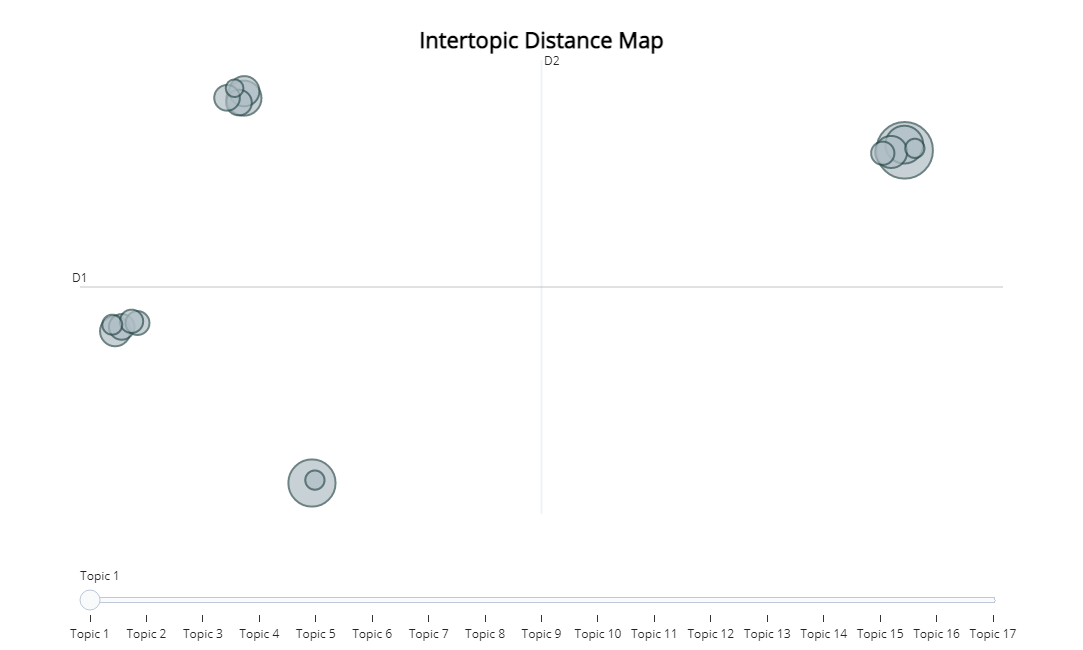

In [52]:
fig = topic_model.visualize_topics()
fig.write_html(f'pqs_guided_{MINISTRY.lower()}_topic_distance.html')
fig

In [53]:
# Getting representative documents for each topic
representative_docs = topic_model.get_representative_docs()

representative_docs_preprocessed = dict()
for topic_num in representative_docs.keys(): 
    entries = []
    for text in representative_docs[topic_num]:
        entries.append(df_ministry[df_ministry[qn_col].str.contains(text)][qn_raw_col].values[0]) # Obtain original text
    representative_docs_preprocessed[topic_num] = entries
    
for i in range(max(topics)+1): 
    print('Topic #'+str(i))
    print('Topic Size: ' + str(Counter(topics)[i]))
    print([x[0] for x in topic_model.get_topic(i)[:15]])
    
    display(pd.DataFrame(representative_docs_preprocessed[i]))
    print('-------------------------------')

Topic #0
Topic Size: 213
['sport', 'athlete', 'game', 'football', 'team', 'event', 'hub', 'sport hub', 'stadium', 'sport facility']


,0
0,"Mr Chairman, the Sports Hub is opening in mid-June this year, and a whole range of sporting events and festivals has been lined up in the Sports Hub calendar. I am sure many Singaporeans will be able to participate in the activities at the Sports Hub in one way or another. Besides these events, the Sports Hub will also be gearing up to host the 2015 SEA and ASEAN Para Games. I would like to ask the Minister if the Public Private Partnership (PPP) framework for the Sports Hub development has served its purpose and met its original objectives. With just slightly more than a year to go, I would also like to ask the Minister for an update on the preparation for the SEA and ASEAN Para Games in 2015."
1,"(a) whether the statement of accounts and financial statements of the 2015 South East Asian Games will be disclosed to the public; (b) if so, when and, if not, why not; and (c) whether there are any net gains or deficits incurred by the 2015 SEA Games 2015 and, if so, what are they."
2,"Mr Chairman, in the same evening after he had beaten Lin Dan, the two-time Olympic champion and five-time world champion at the Thai Masters on 12 January, Singapore’s shuttler Loh Kean Yew wrote the following text to the younger players in the National Intermediate Squad. With permission, I quote: “What kept me going was the gentle reminders that I played the game because I loved it. I worked, listened and learnt from all the coaches and experience players. I persevered when the going got tough because I was hungry to reach my dreams. Being in NIS is a privilege that you should cherish. You guys are lucky to have support from different resources to help improve your badminton. Treasure it and don’t waste it. Set a goal, big enough for people to laugh at. They laugh because it’s impossible for them. They’re the weakling, not you. Work hard towards it. I really must add that the key word is ""discipline"". It is a word that should be applied in everything that you do, be it training, studies, time management. Discipline is not something that should be reflected in only badminton. Discipline should be applied in every aspect of your life. This truly reflects the character of a true champion"". Mr Chairman, sport inspires, sport unites. Sport builds character. Kean Yew's achievement is an inspiration to all who love sports and their nation. Many of the values personified by this young and intrepid player are the same values we seek to promote and embrace in Vision 2030. Would the Minister update us on the key achievements of Vision 2030 since its launch seven years ago?"


-------------------------------
Topic #1
Topic Size: 112
['muslim community', 'mosque', 'religious', 'asatizah', 'mendaki', 'malay muslim community', 'opportunity', 'islamic', 'malay community', 'muslim organisation']


,0
0,"Mr Chairman, M³ has grown in strength and we will continue to work hand-in-hand with the various Malay/Muslim organisations and volunteers to ensure that our programmes are effective in meeting the evolving needs of the Malay/Muslim community and ensure no one is left behind. The community has also made significant progress as a result. The gotong royong spirit is one we must encourage – where community members look out for one another and where we empower them to be contributing members of our society. This sense of citizenry will carry us far in navigating uncertainties ahead of us, together with the rest of Singapore."
1,"Mr Chairman, our young asatizah can be great assets to the community, beyond the mosque and the madrasah. We must continue to invest in their development. In turn, I hope that our young aspiring asatizah will rise to the occasion, be the confident guides that the community needs to navigate future challenges and contribute to the vision of a Muslim community of success and help us build a strong and cohesive Singapore."
2,"First, a question for the Minister for Muslim Affairs, on the mosque building planning, I am heartened by the new mosque that has been announced. But Minister, in terms of mosque planning, do we consider foreign workers who may also be using the mosques as well? Today, that contributes to quite a bit of mosque capacity issues. For Minister Grace Fu, just a quick answer to your question earlier, the MP football team is still in place. There is a match coming up on 21 May 2016."


-------------------------------
Topic #2
Topic Size: 78
['art', 'art culture', 'artist', 'art group', 'heritage', 'cultural', 'museum', 'creative', 'theatre', 'traditional']


,0
0,"Sir, the local arts scene has grown much more robust and vibrant in the recent years. This is heartening. The 2016 statistics from the Ministry indicate that more Singaporeans are taking an active interest in arts and culture, enjoying museums, performing arts and visual art activities. The keen interest can be seen in both ticketed, as well as free events. The number of arts and cultural companies and arts societies has also been increasing lately. The data from MCCY is a useful indicator that our arts scene is indeed growing, but certainly, there is more to it than numbers. I would like to ask the Minister for an update on how the arts scene has developed over the last few years, especially since in Budget 2014, MCCY has set aside an additional $20 million over five years to promote our artists, unique heritage, as well as cultural assets overseas. How effectively have these funds been utilised and how has this helped to develop our local arts creators? Moving forward, what strategies will be employed to further develop our arts scene? Can the Minister share the plans to enhance engagement and education in relation to arts, especially for youth and children? Art enlivens our community, as well as outdoor spaces, and creates shared memories for Singapore. Displaying art in public brings it closer to the people, eradicating the notion that art is only for a specific group of people. From the heartlands, places of interest, business and shopping districts to the MRT stations, it has become a common sight to see local artists and tourists whipping out their phones to take photographs, as well as people waiting by these art pieces which they have now embraced as landmarks. More importantly, several of all these art pieces are commissioned to local artists, making public spaces an ideal platform to gain exposure. The various free guide trails deserve more awareness as they are perfect opportunities to instil knowledge on heritage and culture to Singaporeans. Can MCCY update on the Public Art Trust? Are there plans to bring arts to more spaces? The rise of the ""gig economy"" brings about many exciting opportunities for freelancers who aspire to be their own boss, pick their own projects and work flexible hours. In reality, the situation is not always rosy for the majority. Aside from the lack of a stable income, freelancers grapple with a myriad of legal and administrative challenges. Last year’s results of the Graduate Employment Survey indicated that there is an increase in freelance and part-time jobs being evident among graduates from courses in the arts and humanities. This would largely be attributed to the nature of their work, which is mostly project-based and spans across a specific duration. The Government has introduced measures to help this group of freelancers. The Work Mentorship Programme by WSQ aims to give junior creative freelancers a head start through hands-on-training and mentorship with companies. This is a good scheme in principle. I would like to ask how has the response been from participants, and what can be done to enhance the scheme? Last year, a free handbook was also launched to educate and inform creative freelancers about their legal rights. Thus far, how effective has been in mitigating the problems that freelancers face from errant clients? The gig economy is fast becoming a global trend. We can only expect more creative freelancers to enter the industry, whether by choice or by circumstances. What is the Government doing to increase support for freelancers within the arts industry?"
1,"Sir, physical venues like the museums and art theatres were forced to close and events were suspended at the peak of the pandemic last year. Consequently, many local arts and culture practitioners were hit swiftly and severely. The Government's broad-based support measures and the Arts and Culture Resilience Package would have helped to provide some buoyancy but it remained challenging. Thankfully, many of th

-------------------------------
Topic #3
Topic Size: 50
['mendaki', 'childcare', 'primary', 'operator', 'school education', 'childcare centre', 'mt', 'primary school', 'childrens', 'mcys']


,0
0,whether the Ministry will consider collaborating with the private sector to set up subsidised childcare centres in the vicinity of organisations with employees exceeding 200 in strength.
1,"(a) what is the current number of childcare centres and how many qualified early childhood educators are there in Singapore; and (b) whether there is a shortage of these educators and, if so, what measures are in place to address this shortage."
2,over the past 24 months (a) how many new void deck childcare centres are allocated to PAP Community Foundation (PCF) and NTUC First Campus respectively; (b) what is the average set up and furnishing grant given to each of these two operators per new centre; (c) how does the Ministry decide on the allocation of new centres to these two operators; and (d) what recurrent and other grants have been given to these two operators.


-------------------------------
Topic #4
Topic Size: 43
['cdc', 'charity', 'voucher', 'comcare', 'fund raise', 'cdc comcare', 'cdc voucher', 'fundraise', 'rule', 'consultant']


,0
0,whether local businesses can access the facilities at the new Outward Bound Singapore (OBS) to be built at Coney Island for their team-building activities as the existing OBS at Pulau Ubin no longer caters to businesses.
1,"(a) to date, what is the proportion of (i) heartland merchants that have onboarded the CDC Vouchers Scheme out of all eligible merchants and (ii) CDC Vouchers utilised out of the total given; and (b) whether the Government will consider adapting the CDC e-voucher system to enable charities and philanthropic individuals to use the platform to give e-vouchers to be spent at heartland shops."
2,"whether the Ministry can provide guidelines, including a list of the relevant authorities or regulators of charities in overseas jurisdictions, for donors in Singapore who wish to donate to charities based overseas."


-------------------------------
Topic #5
Topic Size: 36
['madrasah', 'teacher', 'religious', 'madrasah student', 'irsyad', 'madrasah wak', 'wak', 'wak tanjong', 'madrasah wak tanjong', 'al']


,0
0,(a) what is the current number of madrasah teachers in Singapore; (b) what is the number of madrasah teachers who have benefitted from (i) Teachers Development Capitation Grant (ii) MUIS-led Teacher Development Programmes and (iii) Teachers Training Support Grant; and (c) whether MUIS or the Ministry is working towards programmes to equip madrasah teachers with the necessary skills to deal with mental health issues among their student population.
1,"Last year, the Minister announced plans for Madrasah Al-Arabiah to have a new home in Toa Payoh. This is good news as the existing building is old and a makeover is long overdue. However, what is important to me is the madrasah's environment, and not merely its physical aspect. These days, mainstream schools that are part of the national education system are equipped with facilities and technology to keep up with the times and provide the children with the necessary exposure to the relevant technology. I would like to know how the building design and the infrastructure of the new madrasah will encourage the learning of new skills and knowledge among its students, and are also relevant for our modern society in this digital era? Furthermore, how can the students and the school interact with and contribute to the heartland community around the area? Thank you."
2,"The Madrasah education system has come a long way. I personally know many former madrasah students who are now notable alumni. Other than producing reputable Muslim scholars, there are also madrasah graduates who are now business leaders, scientists, social science researchers, lawyers and many more. There are two Madrasah located in M³@Jalan Besar. Recently, I visited Madrasah Aljunied to thank them for their success and congratulate them on passing the IB Programme. All 25 students in the IB programme passed the exams, and their average score is higher than the average global scores. I want to take this opportunity to congratulate the principal of Madrasah Aljunied, as well as the teachers and students for their success once again. The IB programme creates new pathways for madrasah students to non-religious opportunities. In this regard, the students should also be given exposure like attachments in various non-religious sectors. Can the Minister share any plans to further value-add the madrasah curriculum in creating opportunities for madrasah students to gain experience beyond the religious sector?"


-------------------------------
Topic #6
Topic Size: 32
['generation', 'asean', 'aspiration', 'opportunity', 'national youth', 'enterprise', 'volunteerism', 'social enterprise', 'youth programme', 'engage youth']


,0
0,"Madam, three points of clarification. First, is on alumni. I would like to ask the Minister how will his Ministry directly or indirectly continue to engage the alumni. Development is a continuum and not in a discrete manner such that after they have graduated from the programmes, they continue to be active in the volunteering scene or in the community. Second, will the Minister assure that there will continue to be a careful mix of programmes such that there will not just be programmes catering to a certain demographic of youths, but there will be platforms whereby youths of different interests and background can come together and get to know one another more? The third and last point, I would like to ask the Minister what is the definition of success for youth programmes and engagement?"
1,"Chairman, during the Budget debate, I spoke about getting our youth to think ASEAN. It is important for Singapore, especially our youth to understand, network and integrate with other ASEAN countries, given ASEAN's rising economic force and driver of global growth. It is more important than ever that our youth learn more about the region, instead of looking only at the traditional markets like the West and China. What are the Ministry's plans to strengthen cultural and people-to-people ties within ASEAN during Singapore's Chairmanship year? Does MCCY plan to use this opportunity as ASEAN Chair to help integrate our youth with the ASEAN community, and to get our youth to feel more to think ASEAN? How can we encourage our youth to further explore the opportunities available to them in ASEAN, and to experience all the cultures and experiences that ASEAN neighbours can offer? I also hope for our youth also get the chance to see the economic dynamism and opportunities within ASEAN. Lastly, is there more that MCCY can do to work together with MTI and MOE, through a whole-of-Government approach, to shift our youth's mindset to think ASEAN?"
2,"(a) whether there any initiatives to support youths who are engaged in the unskilled gig economy and who want to move away from it; and i(b) if so, what are the current efforts being made to ensure that the youths are aware of these opportunities."


-------------------------------
Topic #7
Topic Size: 32
['household', 'zakat', 'financial assistance', 'average household', 'household income', 'reject', 'needy', 'number application', 'social worker', 'household size']


,0
0,"(a) for each year from 2011 to 2013, what is the average monthly number of feedback received by MUIS on their financial assistance scheme(s); (b) what are the most common areas of concern; and (c) what procedures and processes has MUIS put in place to enhance the services rendered to needy families."
1,in respect of the Public Assistance Scheme for each of the years from 2006 to 2011 (a) what was the number of applications to the Scheme; (b) what was the percentage of applications that were rejected; (c) what were the reasons for rejection and their percentages; and (d) what kinds of follow-up checks or assistance were provided to rejected applicants.
2,"Sir, I would like to thank the Minister for his response. A supplementary question: what are the factors taken into consideration in determining the suitable household income ceiling for both of these programmes?"


-------------------------------
Topic #8
Topic Size: 23
['pa', 'bank', 'auditor', 'car', 'ma', 'auditor general', 'interest rate', 'contract', 'loan', 'lta']


,0
0,"with regard to the Report of the Auditor-General for FY2018/19, what is the reason for the AGO's conclusion that it may be too late to recover the overpayment of $13 million from the contractor in its audit finding of improper waiver of contractual provision for the National Gallery development project."
1,(a) what lessons are learnt from payment irregularities uncovered by the Auditor General's Office amounting to $1.17 million made by PA to two contractors; and (b) what control measures have been instituted to ensure such irregularities do not recur.
2,"in view of the Report of the Auditor General for FY12/13 (a) what are the reasons for the failure to refund Haj administration fees to the 2,369 applicants who cancelled their applications; (b) with regard to the tender called by MUIS in 2007 and 2010 for the supply of korban sheep and ancillary services (i) what is the basis for the contract to be awarded even though the selected vendor did not fulfil some of the mandatory criteria; (ii) what are the reasons behind the irregularities found in the tender process; and (iii) whether the principles of transparency, and open and fair competition have been properly adhered to during the process."


-------------------------------
Topic #9
Topic Size: 23
['political', 'pa', 'grassroots', 'party', 'political party', 'appoint', 'letter', 'government agency', 'adviser', 'branch']


,0
0,"I have two questions. One is for Minister Yaacob Ibrahim and one for Minister Chan Chun Sing. For Minister Yaacob Ibrahim, I would like to ask regarding the announcement made by Minister about MUIS rendering financial assistance to help Madrasah Wak Tanjong Al-Islamiyah (MWTI) with the payment of the land lease. Firstly, I have to declare that I have a child who is schooling in Madrasah Wak Tanjong Al-Islamiyah. So, I just want to know, by accepting this assistance, what are the terms and conditions that are placed upon MWTI by MUIS, for example is MWTI required to join the Joint Madrasah System? Secondly, are members of the MWTI management board to be appointed by MUIS from henceforth, if yes, how many of the members? For Minister Chan Chun Sing, my speech is to ask for clarification, it is not about asking or clarifying about whether any Government agencies accept letters written by any political parties' members. The Minister mentioned Mr Leon Perera, who is also a Non-Constituency Member of Parliament. My question is about the issue of politicisation and conflict of interest where a particular grassroots advisor goes for the house visits, invites the people to come to his Meet-the-People session, which is being held in a political party branch office and the letter written on behalf of the residents is signed off by this particular person who holds two designations: grassroots advisor and political party branch chairman. And, the letterhead being used for this appeal letter bears the name of the political party. So, I just want to know, from Minister's point of view, is there any element of politicisation as well as conflict of interest in this particular example that I have mentioned. I would like to give one more example, so hopefully Minister can give a direct answer to this."
1,"Thank you, Sir. Minister Chan Chun Sing in his earlier reply on the PA talked about political outreach. I would like to seek clarification from him. PA activities are headed by grassroots advisor, who is a PAP Member of Parliament, and also a prospective PAP candidate, who is also appointed as the grassroots advisor, or previous candidate of PAP heading activities on the ground. Are these activities not considered as political outreach?"
2,"Madam, I have a clarification for Minister Chan on People's Association. First, I welcome this unequivocal public statement that the PA should never be politicised. It is a timely reminder to those who may think otherwise. My clarification concerns his confirmation that the PA is a statutory board. I would like to ask whether as a Government agency, the PA also adopts the Government SOP that it will reply to Members of Parliament's letters written on behalf of their constituents."


-------------------------------
Topic #10
Topic Size: 23
['religious', 'racial', 'harmony', 'religion', 'divide', 'fault line', 'fault', 'race religion', 'difference', 'pandemic']


0
0  Chairman, the disruption to our economy from the pandemic has had different impact on various segments of our country. COVID-19 has inflicted disproportionate hardship upon those who are less well-off and pushed those at the margins into further difficulties. To make matters worse, rampant misinformation on the internet and social media platforms is adding to the turbulence. Our world is under many stresses and these have the potential to deepen societal divisions, especially those along religious and racial fault lines. There is much work to be done to narrow the gaps. We need to foster a cohesive and caring society in order to recover and forge ahead as one nation. Would MCCY share its strategies on how it will work with Singaporeans to close ranks and become a more united and resilient people? How will the Government ensure that in our fight against the pandemic and consequent chaos, no one is left behind? One of my greatest concerns is the state of racial and religious harmony in Singapore. It is threatened by radicalisation of troubled individuals and groups. The most recent case was that of a 16-year-old student of Protestant faith who plotted to attack two mosques and kill Muslim worshippers here. A few churches in my constituency reached out to the Masjid Jamek Queenstown, also in my division, for a sharing and meal together as an expression of solidarity, to deepen the ties between both faiths and condemned the incident. Strengthening religious harmony is an on-going work in progress. We are one of the most religiously diverse countries in the world. Mutual respect and tolerance are qualities that we must all conscientiously nurture and practice, and teach our young. I commend MCCY for its work to build up religious tolerance among our people and look forward to hearing its new initiatives. I propose MCCY facilitating regular sharing sessions among our different faiths which is key to building trust and understanding. Similarly, we need to put in effort to encourage Singaporeans to do their part to build racial harmony. The more we interact with members of different racial communities, the better we can understand one another and learn that in fact, we have so much more in common than differences. What is exciting for me is that there is much wisdom we can gather from those who are different from us. Would MCCY share the projects and initiatives it has in store to further enhance our racial harmony? One of the silver linings from the COVID-19 pandemic is how it ignited the spirit of “gotong royong” in our society. There are various interpretations and translations for this phrase, including “active citizenry”, “cooperation in a community” and “mutual aid”. My favorite is “carrying burdens together” because gotong means "carrying a burden using one's shoulder" and royong means "together" or "communally". Carrying burdens together implies a willingness to help another lighten his load. It means stepping forward to volunteer and lend a helping hand. During this crisis, many individuals, businesses and community groups have indeed stepped up. They voluntarily contributed time, energy and money to organise their own ground-up initiatives to assist those in need. This outpouring of selflessness brought strangers and the community together in a common cause. I am heartened and inspired by the efforts of our people to work together for the benefit of our community. I earnestly hope that we will be able to continue the momentum and sustain this spirit of mutual care, trust and understanding. Even as we are helping the needy, we are simultaneously building bonds across religious, racial and cultural boundaries, and learning more about ourselves and our Singapore identity. A student volunteer shared how he would never look at a packet of food the same way again after helping to distribute packets of meals to some needy families. Coming from a very comfortable background, it was hard for him to visualise food insecurity in o

-------------------------------
Topic #11
Topic Size: 20
['dispute', 'mediation', 'tribunal', 'resolution', 'neighbour', 'cdrt', 'community dispute', 'dispute resolution', 'party', 'parliamentary secretary']


,0
0,whether he can provide an update on (i) the review of the Community Dispute Management Framework by the inter-agency committee and (ii) mediation being made compulsory prior to filing of Community Disputes Resolution Tribunal (CDRT) cases to manage and resolve disputes between neighbours.
1,when will the Community Disputes Resolution Tribunals be set up and made operational.
2,in respect of a proposed Inter-Ministry framework for compulsory community mediation for disputes (a) whether public consultations have begun; (b) what progress has been made to date on the design of the framework; and (c) when will the framework be put in place.


-------------------------------
Topic #12
Topic Size: 19
['haj', 'korban', 'halal', 'pilgrimage', 'sheep', 'livestock', 'quota', 'import livestock', 'import', 'korban ritual']


,0
0,(a) how does MUIS plan to address the shortage of Haj pilgrimage places in view of the much lower quota allocated to Singapore recently; (b) how many Muslim Singaporeans were affected by this recent quota change and suffered losses as a result of early bookings; and (c) how does MUIS plan to handle the backlog and expected waiting list should the lower quotas continue over the next few years.
1,"Mr Speaker, I would like to thank the Minister for his comprehensive reply. I would like to ask whether there has been any review conducted on the Haj system, which is managed by MUIS, since last year's unfortunate Haj circumstances. If yes, were there any irregularities discovered and how were these addressed?"
2,"(a) whether MUIS and the Association of Muslim Travel Agents (AMTAS) receive a portion of the monies paid by pilgrims to their respective general sales agents for the pilgrimage package; and (b) if so, whether pilgrims are informed of this and what is the total amount collected and its proportion in relation to the total sum received in the last three years."


-------------------------------
Topic #13
Topic Size: 19
['taxi', 'bus', 'commuter', 'transport', 'public transport', 'driver', 'taxi driver', 'security', 'bus service', 'lta']


0
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             (a) what is the progress on busking pilots to test out the safe management measu

-------------------------------
Topic #14
Topic Size: 14
['facilitator', 'empower', 'company', 'grind initiative', 'cdc', 'spirit', 'centre town', 'base volunteer', 'community development', 'network']


,0
0,"Mdm Chair, last year, I spoke on this and brought up the dip in volunteering when youths leave school and enter the workforce. The Minister pointed out then that a key barrier to volunteering occurs when individuals enter the workforce. Although there are more Singaporeans engaged in volunteer work today as compared to the past, we have yet to be able to engage companies in a sustainable way. Corporates have the financial and professional capabilities to do more in Singapore, and I believe employees have the skills and the heart to contribute more in terms of volunteering. How can we urge more companies, including their top leadership, to drive more giving efforts? Early this year, the SG Care and Share Day was launched as the inaugural volunteering event for SG50. It is a good initiative to have an annual event that engages the public and promotes the awareness of volunteering. In October last year, there was also a ""Redefining Community Giving"" conference that looked at other ways of giving to society and also skills-based volunteering. Skills-based volunteering is win-win for both companies and society - skills-based volunteers have been shown to have higher employee morale than non-volunteers, and social organisations benefit from the volunteers' skills and knowledge for capacity-building. Minister Wong had spoken of his Ministry's plans to do more to engage companies, and one way was by working with partners like NVPC and like-minded companies to promote a corporate giving culture. May I ask about the progress of efforts in this area? Has there been a greater involvement of companies so far? Youth Volunteerism and Social Enterprise"
1,"Chairman, one of the ways thus far that MCCY has engaged with our citizens via the Making Stronger Conversations initiative, the platform which operates on a voluntary basis has successfully brought together individuals of diverse backgrounds into conversations to share their ideas and hopes on how to foster a more resilient and inclusive post-COVID-19 society. Given how the pandemic has disrupted social relations, such forms of collaborations among citizens as well as partnership between state and citizen have all become more crucial than ever. How will MCCY continue to provide Singapore from various social groups with not only opportunities to further contribute and develop ideas, but also then translate said ideas into concrete roles and shape the future of Singapore together?"
2,"Mdm Chair, generosity is written in our hearts. But work is needed to bring out this generosity. And as our young society matures, we must establish the social norms that encourage our people to take care of one another, to build a shared future together, to create ties that bind us together. Establishing such social norms is important. To re-word a famous phrase by Winston Churchill − First we build a society, thereafter the society builds us. And no one group by themselves, including the Government, has a monopoly on the ideas to build an ideal Singapore. That is why I am heartened to see MCCY's emphasis on encouraging our citizens to step forward to co-create Singapore. As such, can MCCY provide an update on how the Government is progressing to: one, encourage more Singapore citizens to actively participate in volunteering and charity work? Two, to partner with citizens, social service organisations, and corporations? Three, to move forward initiatives, such as Our Singapore Fund, SGCares, Champions of Good, and Company of Good Fellowship?"


-------------------------------
Topic #15
Topic Size: 13
['heritage', 'artefact', 'monument', 'national monument', 'survey', 'world heritage', 'site', 'museum', 'unesco world', 'unesco world heritage']


,0
0,"(a) how much money has been raised through the Tax Exemption Scheme for Donations to National Monuments over the last five years; (b) whether the scheme has been effective in helping the owners of national monuments raise funds and donations for the restoration works of their buildings; and (c) other than financial assistance, whether the Preservation of Monuments Board provides owners of national monuments with technical advice on maintaining historic buildings, including access to architectural conservation specialists for consultation."
1,"with regard to the upcoming survey on intangible cultural heritage (a) how will the vendors be evaluated for their expertise in conducting the survey; (b) whether all findings of the survey and findings from previous research done by the National Heritage Board will be released to the public and, if not, why not; and (c) whether there will be extensive public consultations in the creation of the national inventory."
2,"(a) in the last five years, how many owners and users of gazetted national monuments have utilised the Tax Exemption Scheme for Donations to National Monuments and what is the total value of tax exemptions granted; (b) how much has been disbursed through the National Monuments Fund in the last five years for the restoration of national monuments; and (c) whether more can be done to promote the use of existing schemes to preserve and enhance our national monuments."


-------------------------------
Topic #16
Topic Size: 13
['divorce', 'couple', 'marriage', 'court', 'syariah court', 'syariah', 'appeal', 'husband', 'ex', 'marry']


,0
0,"(a) from 2011 to 2020, how many cases of Muslim divorce are classified under (i) talak rajie (ii) talak bain (iii) taklik (iv) fasakh and (v) khuluk; (b) how many of these divorce cases have been pronounced by hakam; and (c) how many cases are presented to the second set of hakam."
1,"(a) from 2017 to 2019, what is the annual number of appeals received by the MUIS Appeal Board regarding judgments issued by the Syariah Court of Singapore for divorce cases; (b) what are the main reasons for the appeals; and (c) how many cases are reported by ex-husbands and ex-wives respectively."
2,"(a) what is the percentage of divorces in the Syariah Court that has resulted in shared care and control of the children; and (b) for all cases resulting in shared care and control, what is the proportion of these cases which have complaints or appeals being filed in court or to a government agency related to frictions arising from policies affecting such families, such as subsidised housing, in the (i) Family Justice Courts and (ii) Syariah Courts."


-------------------------------
Topic #17
Topic Size: 11
['ttfs', 'loan', 'malay student', 'mendaki', 'loan give', 'asatizahs', 'educational', 'tuition', 'repayment', 'tertiary']


,0
0,"Mr Chairman, I have a question for Minister Yaacob Ibrahim with regards to MENDAKI loans. I presume at this time there are some who are unable to din the loan or pay back the loan. Can the Minister share with us how much in terms of statistics that this is now happening?"
1,"Thank you, Mr Chairman. I would like to address this to Minister Yaacob Ibrahim. For students who are already on the TTFS and they get, for example the 50% subsidy under the TTFS, can they re-apply under the new criteria? My second question Minister, is how much more in terms of Budget allocation will this increase in TTFS costs the Government?"
2,"Sir, it is a good question. We are studying it to ensure that whatever loans that we give and the rate of repayment can allow us to have a sustained programme. I can safely say that in the last few months or at least a year or so, MENDAKI's staff have been working very hard to be able to get repayment. We understand sometimes when the circumstances do not allow it because of circumstances, because they cannot get a job, we are prepared to delay. But over the years, the numbers of delayed payments have come down and I think that is very good news for the community. I am not at liberty to share the details. We are doing a deep dive to ensure that we have the right policy level to ensure that Malay/Muslim students who need study loans are given the right quantum with an assurance of their ability to pay back because the money does not belong to us, it belongs to the community. We just want to make sure that the repayment rate is in such a way that we can sustain the loans that we give out and what other expenditure MENDAKI needs to make use of."


-------------------------------


In [54]:
# # Getting examples for each topic
# num_examples = 2

# for i in range(max(topics)+1): 
#     print('Topic #'+str(i))
#     print('Topic Size: ' + str(Counter(topics)[i]))
#     print([x[0] for x in topic_model.get_topic(i)[:15]])
    
#     display(pd.DataFrame(df_ministry[[qn_raw_col, 'question_len']][df_ministry['question_topic'] == i].sample(num_examples).sort_values(by = 'question_len')))
#     print('-------------------------------')

In [55]:
# Examining Key Topics for each Theme
## Prints the top 3 topics and the top 5 keywords/phrases associated with each topic

for asker_name in df_ministry['asker_name'].unique().tolist():
    print(asker_name)
    asker_df = df_ministry[df_ministry['asker_name'] == asker_name].copy()
    
    count = pd.DataFrame(asker_df['question_topic'].value_counts()).reset_index()
    count.columns = ['question_topic', 'count']
    count = count[count['question_topic'] != -1].copy().reset_index(drop = True)
    
    for i in range(0, min(3, len(count['count'].values))):
        topic = count['question_topic'].values[i]
        print(i+1, '. Topic #', topic, ' (', round(count['count'].values[i]/len(asker_df)*100, 1), '%) - ',
              ', '.join([x[0] for x in topic_model.get_topic(topic)[:5]]),
              sep = '')
    print('---')

Lim Wee Kiak
1. Topic #0 (30.0%) - sport, athlete, game, football, team
2. Topic #10 (15.0%) - religious, racial, harmony, religion, divide
3. Topic #2 (10.0%) - art, art culture, artist, art group, heritage
---
Amrin Amin
1. Topic #5 (37.5%) - madrasah, teacher, religious, madrasah student, irsyad
2. Topic #1 (37.5%) - muslim community, mosque, religious, asatizah, mendaki
---
Muhamad Faisal Bin Abdul Manap
1. Topic #0 (13.5%) - sport, athlete, game, football, team
2. Topic #7 (11.5%) - household, zakat, financial assistance, average household, household income
3. Topic #1 (10.6%) - muslim community, mosque, religious, asatizah, mendaki
---
Saktiandi Supaat
1. Topic #1 (36.8%) - muslim community, mosque, religious, asatizah, mendaki
2. Topic #3 (10.5%) - mendaki, childcare, primary, operator, school education
3. Topic #5 (10.5%) - madrasah, teacher, religious, madrasah student, irsyad
---
Mohamed Irshad
1. Topic #1 (60.0%) - muslim community, mosque, religious, asatizah, mendaki
2. To

In [56]:
# for each topic, which mps are most prominent? impt cuz u wanna find out which mp to approach right

for topic in sorted(df_ministry['question_topic'].unique().tolist()):
    if topic == -1:
        continue
    print(f'Topic #{topic} - {", ".join([x[0] for x in topic_model.get_topic(topic)[:5]])}')
    topic_df = df_ministry[df_ministry['question_topic'] == topic].copy()
    
    count = pd.DataFrame(topic_df['asker_name'].value_counts()).reset_index()
    count.columns = ['asker_name', 'count']
    
    for i in range(0, min(3, len(count['count'].values))):
        asker_name = count['asker_name'].values[i]
        print(i+1, '. ', asker_name, ' (', round(count['count'].values[i]/len(topic_df)*100, 1), '%)', sep='')
    print('---')

Topic #0 - sport, athlete, game, football, team
1. Nicholas Fang (10.3%)
2. Lee Bee Wah (8.5%)
3. Muhamad Faisal Bin Abdul Manap (6.6%)
---
Topic #1 - muslim community, mosque, religious, asatizah, mendaki
1. Muhamad Faisal Bin Abdul Manap (9.8%)
2. Zainal Sapari (9.8%)
3. Zaqy Mohamad (8.9%)
---
Topic #2 - art, art culture, artist, art group, heritage
1. Janice Koh (19.2%)
2. Terence Ho Wee San (14.1%)
3. Kok Heng Leun (7.7%)
---
Topic #3 - mendaki, childcare, primary, operator, school education
1. Yee Jenn Jong (16.0%)
2. Zaqy Mohamad (12.0%)
3. Low Yen Ling (8.0%)
---
Topic #4 - cdc, charity, voucher, comcare, fund raise
1. Louis Ng Kok Kwang (9.3%)
2. Png Eng Huat (7.0%)
3. Leon Perera (7.0%)
---
Topic #5 - madrasah, teacher, religious, madrasah student, irsyad
1. Muhamad Faisal Bin Abdul Manap (22.2%)
2. Zainal Sapari (16.7%)
3. Intan Azura Mokhtar (13.9%)
---
Topic #6 - generation, asean, aspiration, opportunity, national youth
1. Tin Pei Ling (21.9%)
2. Alex Yam Ziming (12.5%)
3

### 2.4. Adding Topic Labels Based on Human Interpretation

In [57]:
# note to self: can merge topics if the intertopic distance is very small. just give same label.

topic_labels = {
    
    -1: np.nan,
    0: 'Sports', 
    1: 'Malays and Muslims',
    2: 'Culture and The Arts',
    3: 'Childhood Education and Childcare',
    4: 'Charity',
    5: 'Islamic Education',
    6: 'Youth Engagement',
    7: 'Financial Assistance',
    8: 'PA Audits',
    9: 'Politicization of Grassroots',
    10: 'Societal Division',
    11: 'Neighbourhood Disputes',
    12: 'Muslim Rituals',
    13: 'Transport',
    14: 'Social Organisations', 
    15: 'Heritage',
    16: 'Marriage',
    17: 'Bursaries'
}

In [58]:
# Adding Topic Labels to data
df_ministry['question_topic_label'] = df_ministry['question_topic'].map(topic_labels)
#df_ministry.head(2)

In [59]:
print('Number of question rows with no topic label: ', df_ministry['question_topic_label'].isnull().sum(),
      ' (', round(df_ministry['question_topic_label'].isnull().sum()/len(data)*100,1), '%)',
      sep = '')

pd.DataFrame(df_ministry['question_topic_label'].value_counts())

Number of question rows with no topic label: 278 (26.4%)


,question_topic_label
Sports,213
Malays and Muslims,112
Culture and The Arts,78
Childhood Education and Childcare,50
Charity,43
Islamic Education,36
Youth Engagement,32
Financial Assistance,32
Politicization of Grassroots,23
PA Audits,23


In [60]:
# Seeded topics that didn't emerge during topic modelling
[x for x in list(anchor_dict.keys()) if x not in df_ministry['question_topic_label'].unique().tolist()]

['Politicization of the Arts',
 'Prioritising Singaporeans and the Less Fortunate']

In [61]:
# Export file 
df_ministry.to_csv(f'pqs_guided_topic_modelling_results_{MINISTRY.lower()}.csv', index = False)

In [62]:
df_ministry[[qn_raw_col]][df_ministry[qn_col].str.contains('wellness')]

question
522                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Firstly, I would like to thank the men in the House for the well wishes. I always say we are so blessed to be living in Singapore where ladies are well respected and treated fairly. I cannot ask for more. Mr Chairman, in a 2018 June article from the Straits Times, Minister Grace Fu said that, "Singapore hopes to double its volunteerism rate from one in three currently to 70 per cent in five years' time". This is a laudable goal to aim for, and I believe it can come to fruition through a combination of various factors. As citizens of Singapore, we all take responsibility for our lives and actions. The Government does not believe in giving handouts and it is the civic duty of citizens to help the less fortunate in our country. Currently, the rate of volunteerism in Singapore has grown from 9% in 2000 to 35% in 2016, with the total volunteer hours doubling from 66 million hours in 2014 to 121 million hours in 2016. As it is, the benefits of volunteerism are manifold. It is a source of significant contribution to the global economy. According to statistics from the Johns Hopkins Centre for Civil Society Studies in 2011, approximately 140 million people in the 37 countries engage in volunteer work in a typical year. It is estimated that volunteers contribute around $400 billion